In [2]:
from keras.applications import inception_v3
from keras import backend as K

# 不需要训练模型，
# 所以此命令禁用所有特定于训练的操作
K.set_learning_phase(0)

# 构建InceptionV3网络,该模型将加载预先训练的ImageNet权重。
model = inception_v3.InceptionV3(weights='imagenet',
                                include_top=False)

87916544/87910968 [==============================] - 296s 3us/step


In [4]:
'''
接下来，计算“损失”，即在梯度上升过程中寻求最大化的数量。
同时最大化多个层中所有过滤器的激活。具体来说，将最大化一组高级层激活的L2范数的加权和。
选择的确切图层集（以及它们对最终损失的贡献）对将能够生成的视觉效果有很大影响，因此
使这些参数易于配置。较低层会产生几何图案，而较高层会产生视觉效果，
可以在其中识别ImageNet中的某些类（例如鸟或狗）。
将从一个涉及四层的任意配置开始
'''
# Dict将层名称映射到一个系数，该系数量化了层的激活将导致寻求最大化的损失。
# 这些是在内置的InceptionV3应用程序中出现的图层名称。可以使用`model.summary（）`列出所有图层名称。
model.summary()
layer_contributions = {
    'mixed2': 0.2,
    'mixed3': 3.,
    'mixed4':2.,
    'mixed5':1.5,
}

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, None, None, 3 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, None, None, 3 0           batch_normalization_95[0][0]     
__________________________________________________________________________________________________
conv2d_96 

In [6]:
# 定义一个包含损失的张量，即上面列出的激活的L2范数的加权和。
layer_dict = dict([(layer.name, layer) for layer in model.layers])
# 定义损失
loss = K.variable(0.)
for layer_name in layer_contributions:
    # 将丢失的图层特征的L2范数添加到损失中。
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output
    
    # 通过仅涉及损失中的非边界像素来避免边界伪影。
    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    loss += coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [8]:
# 设置梯度上升过程：
# 保存生成的图片
dream = model.input

# 计算损失的梯度的变化
grads = K.gradients(loss, dream)[0]

# 标准化梯度
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

# 设置函数以检索给定输入图像的损失和梯度值。
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x


In [15]:
'''
最后，这是实际的Deep Dream算法。
首先，定义一个“尺度”列表（也称为“octaves”），在其中处理图像。
每个连续的比例比前一个比例大1.4倍（即大40％）：首先处理一个小图像，然后逐渐升级它：
然后，对于每个连续的比例，从最小到最大，们运行梯度上升以最大化先前在该比例下定义的损失。在
每次渐变上升运行后，将得到的图像放大40％。
为了避免在每次连续放大后丢失大量图像细节（导致图像越来越模糊或像素化），利用一个简单的技巧：
在每次放大之后，将丢失的细节重新注入图像，这是可能的，因为知道什么是原始图像看起来应该更大。
给定一个小图像S和一个较大的图像尺寸L，可以计算原始图像（假设大于L）重新调整大小L和原始大小
调整为大小S之间的差异 - 这个差异量化从S开始时丢失的细节到L.

下面的代码利用了以下简单的辅助Numpy函数。
'''
import scipy
import numpy as np
from keras.preprocessing import image

def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
              float(size[0]) / img.shape[1],
              float(size[1]) / img.shape[2],
              1)
    return scipy.ndimage.zoom(img, factors, order=1)

def deprocess_image(x):
    # Util函数将张量转换为有效图像。
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x
    
def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    scipy.misc.imsave(fname, pil_img)
    
def preprocess_image(image_path):
    # Util函数:调整图片大小并将图片格式化为适当的张量。
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img

In [16]:
import numpy as np
# 使用超参数获得新效果
step = 0.01  # 梯度上升步长
num_octave = 3  # 运行梯度上升的比例数
octave_scale = 1.4  # 尺度之间的尺寸比
iterations = 20  # 每个比例的上升步数

#如果损失大于10，我将中断梯度上升过程，以避免ugly artifacts
max_loss = 10.

# 将其填充到要使用的图像的路径
base_image_path = './test.png'

# 将图像加载到Numpy数组中
img = process_image(base_image_path)

# 准备一个形状元组列表，定义了我们将运行梯度上升的不同尺度
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)

# 反转shape列表，使它们按顺序递增
successive_shapes = successive_shapes[::-1]

# 将图像的Numpy数组调整为最小比例
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname='dream_at_scale_' + str(shape) + '.png')

save_img(img, fname='final_dream.png')

Processing image shape (138, 136)
...Loss value at 0 : 0.26012674
...Loss value at 1 : 0.42666528
...Loss value at 2 : 0.6801994
...Loss value at 3 : 1.0506611
...Loss value at 4 : 1.5495763
...Loss value at 5 : 1.89506
...Loss value at 6 : 2.2689116
...Loss value at 7 : 2.726926
...Loss value at 8 : 3.0781224
...Loss value at 9 : 3.5114133
...Loss value at 10 : 3.947701
...Loss value at 11 : 4.4308066
...Loss value at 12 : 4.7854958
...Loss value at 13 : 5.20111
...Loss value at 14 : 5.642894
...Loss value at 15 : 5.903351
...Loss value at 16 : 6.480799
...Loss value at 17 : 6.803378
...Loss value at 18 : 7.2163234
...Loss value at 19 : 7.672877
Processing image shape (194, 190)
...Loss value at 0 : 1.8239505
...Loss value at 1 : 2.7991168
...Loss value at 2 : 3.6743054
...Loss value at 3 : 4.4888363
...Loss value at 4 : 5.387617
...Loss value at 5 : 6.206719
...Loss value at 6 : 7.1246104
...Loss value at 7 : 7.971635
...Loss value at 8 : 8.978709
Processing image shape (272, 267)
..

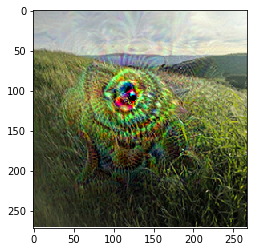

In [17]:
from matplotlib import pyplot as plt

plt.imshow(deprocess_image(np.copy(img)))
plt.show()